In [72]:
from pathlib import Path
import sys
PROJ_NAME = "optimal-stopping"

# Locate the Project directory
curr_dir = str(Path.cwd())
start = curr_dir.find(PROJ_NAME)
if start < 0:
    print("ERROR: Project directory not found")
    print("Make sure you have the correct project structure")
    print("and run the simulation from within the project")
proj_pathname = curr_dir[:(start+len(PROJ_NAME))]

# Create path to the project directory
proj_path = Path(proj_pathname)

# Add the project folder to PATH
sys.path.append(proj_pathname)

In [73]:
from bin.data_import import data_init
from bin.data_import import import_dataset_2 as im
from policies.policy import *
from bin.result import Result
from bin.plot_d2 import *
from linreg.lin_reg_model import get_linear_regression_model as get_model
from linreg.lin_reg_model import k_fold_cv as get_error

SIZE = 100
S=["pi3"]
# Initialising data structure
data_init()
sensor_dataset = im(S)[0]
print(len(sensor_dataset))
sensor_dataset = sensor_dataset.iloc[0:SIZE,:]

264


In [74]:
W=25
theta = 2
B=4

def getNewX(data):
    return data.temperature.values.reshape(-1,1)

def getNewY(data, S=None):
    return data.humidity.values.reshape(-1,1)



In [75]:

data = sensor_dataset.iloc[0:W,:]

# Reshape the temperature and humidity values
init_X = getNewX(data)
# Reshape the sensor values
init_y = getNewY(data, S)
# Build a model to be sent to the Edge Gate
model = get_model(init_X, init_y)
# Evaluate the model
err = get_error(model, init_X, init_y)

err_diff = []
err_storage = [err]
init_err = err
init_model = model

comm_count = 1
comm = [comm_count]

err_sum = err

dataset_length = len(sensor_dataset)

i = 1
Vreward = 0
Vreward_vector = []
while (i + W) <= dataset_length:
    # Receive a new datapoint
    data = sensor_dataset.iloc[i:i+W,:]
    X = getNewX(data)
    y = getNewY(data, S)
    # Build a new model with the newly arrived datapoint 
    # and the discarded oldest datapoint
    new_model = get_model(X, y)
    # Evaluate
    new_err = get_error(new_model, X, y)
    err_storage += [new_err]

    init_model_err = get_error(init_model, X, y)
    err_diff += [abs(init_model_err-new_err)]

    err_sum += err_diff[-1]

    #DECIDE if we should update or not
    if err_sum <= theta:
        Vreward += 1
        Vreward_vector += [Vreward]
    else:
        Vreward = -B
        Vreward_vector += [Vreward]
        Vreward = 0
        init_model = new_model
        err_sum = new_err
        
    # Slide the window with 1
    i += 1


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, -4, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, -4, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, -4, 1, 2, 3, 4, 5, 6, 7, 8, -4, 1, 2, 3, 4, 5]


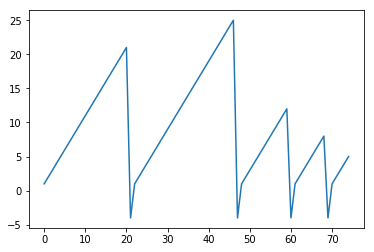

Expected value of M(essages): 4.332755632582325


In [76]:
print(Vreward_vector)
plt.plot(Vreward_vector)
plt.show()
size_Vreward = len(Vreward_vector)
expReward = \
    sum([x*(Vreward_vector.count(x)/size_Vreward) for x in Vreward_vector])
expM = SIZE/expReward
print("Expected value of M(essages):",expM)

In [77]:
from scipy.stats import gamma
import numpy as np

mean = np.mean(err_diff)
var = np.var(err_diff)

shape = mean**2/var
scale = var/mean
print("shape",shape)
print("scale", scale)

cdf = gamma.cdf(sorted(err_diff), shape, scale=scale)
pdf = gamma.pdf(sorted(err_diff), shape, scale=scale)

shape 1.2040382652028505
scale 0.0981466814218533


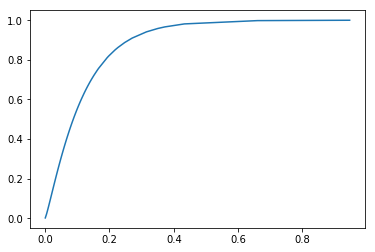

In [78]:
import matplotlib.pyplot as plt

x = sorted(gamma.rvs(shape, scale=scale, size = 100))
plt.plot(x,gamma.cdf(x, shape, scale=scale))
plt.show()

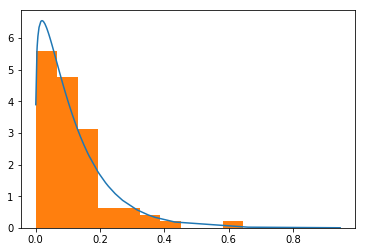

In [79]:
plt.plot(x,gamma.pdf(x, shape, scale=scale))
plt.hist(err_diff, density=True, bins=10)
plt.show()